In [22]:
import os.path
import cv2
import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from fl_tissue_model_tools.topology import (
    compute_morse_skeleton_and_barcode,
    compute_colored_tree_and_barcode,
    plot_colored_tree
)
from pydmtgraph.helper import plotGraph
import gudhi as gd
from skimage import measure, morphology, feature, exposure, filters
from skimage.filters.rank import entropy

In [2]:
# helper functions to preprocess images
def blur(im, n_itr=10, method='gaussian'):
    im_blur = np.copy(im)
    for _ in range(n_itr):
        if method == 'gaussian':
            im_blur = cv2.GaussianBlur(im_blur, (3,3), 0)
        elif method == 'median':
            im_blur = cv2.medianBlur(im_blur, 3)
        elif method == 'simple':
            im_blur = cv2.blur(im_blur, (3,3))
    return im_blur

def sharpen(im, n_itr=10):
    kernel = 1/34 * np.array([[ 0,  0, -1,  0,  0],
                              [ 0, -1, -2, -1,  0],
                              [-1, -2, 17, -2, -1],
                              [ 0, -1, -2, -1,  0],
                              [ 0,  0, -1,  0,  0]])
    im_sharpen = np.copy(im)
    for _ in range(n_itr):
        im_sharpen += np.abs(cv2.filter2D(im_sharpen, -1, kernel))

    return im_sharpen

def remove_small_objects_in_mask(mask: npt.NDArray[np.uint8], min_size: int):
    _, mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)
    inverse_mask = 1 - mask

    labeled_regions_inverse = measure.label(inverse_mask, connectivity=1)
    labeled_inverse_regions = morphology.remove_small_objects(labeled_regions_inverse, min_size=30)

    mask[labeled_inverse_regions == 0] = 1

    labeled_regions = measure.label(mask, connectivity=2)
    labeled_regions = morphology.remove_small_objects(labeled_regions, min_size=min_size)

    mask[labeled_regions == 0] = 0
    mask[mask>0]=255
    return mask

def show(imgs, hw=None, figsize=None, cmap='gray', dpi=300):
    if hw is None:
        hw = (1, len(imgs))
    if figsize is None:
        fig_w = max(5, 5*hw[1])
        fig_h = max(5, 5*hw[0])
        figsize = (fig_w, fig_h)
    fig, axs = plt.subplots(*hw, figsize=figsize, dpi=dpi, constrained_layout=True)
    for i, img in enumerate(imgs):
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
    plt.show()

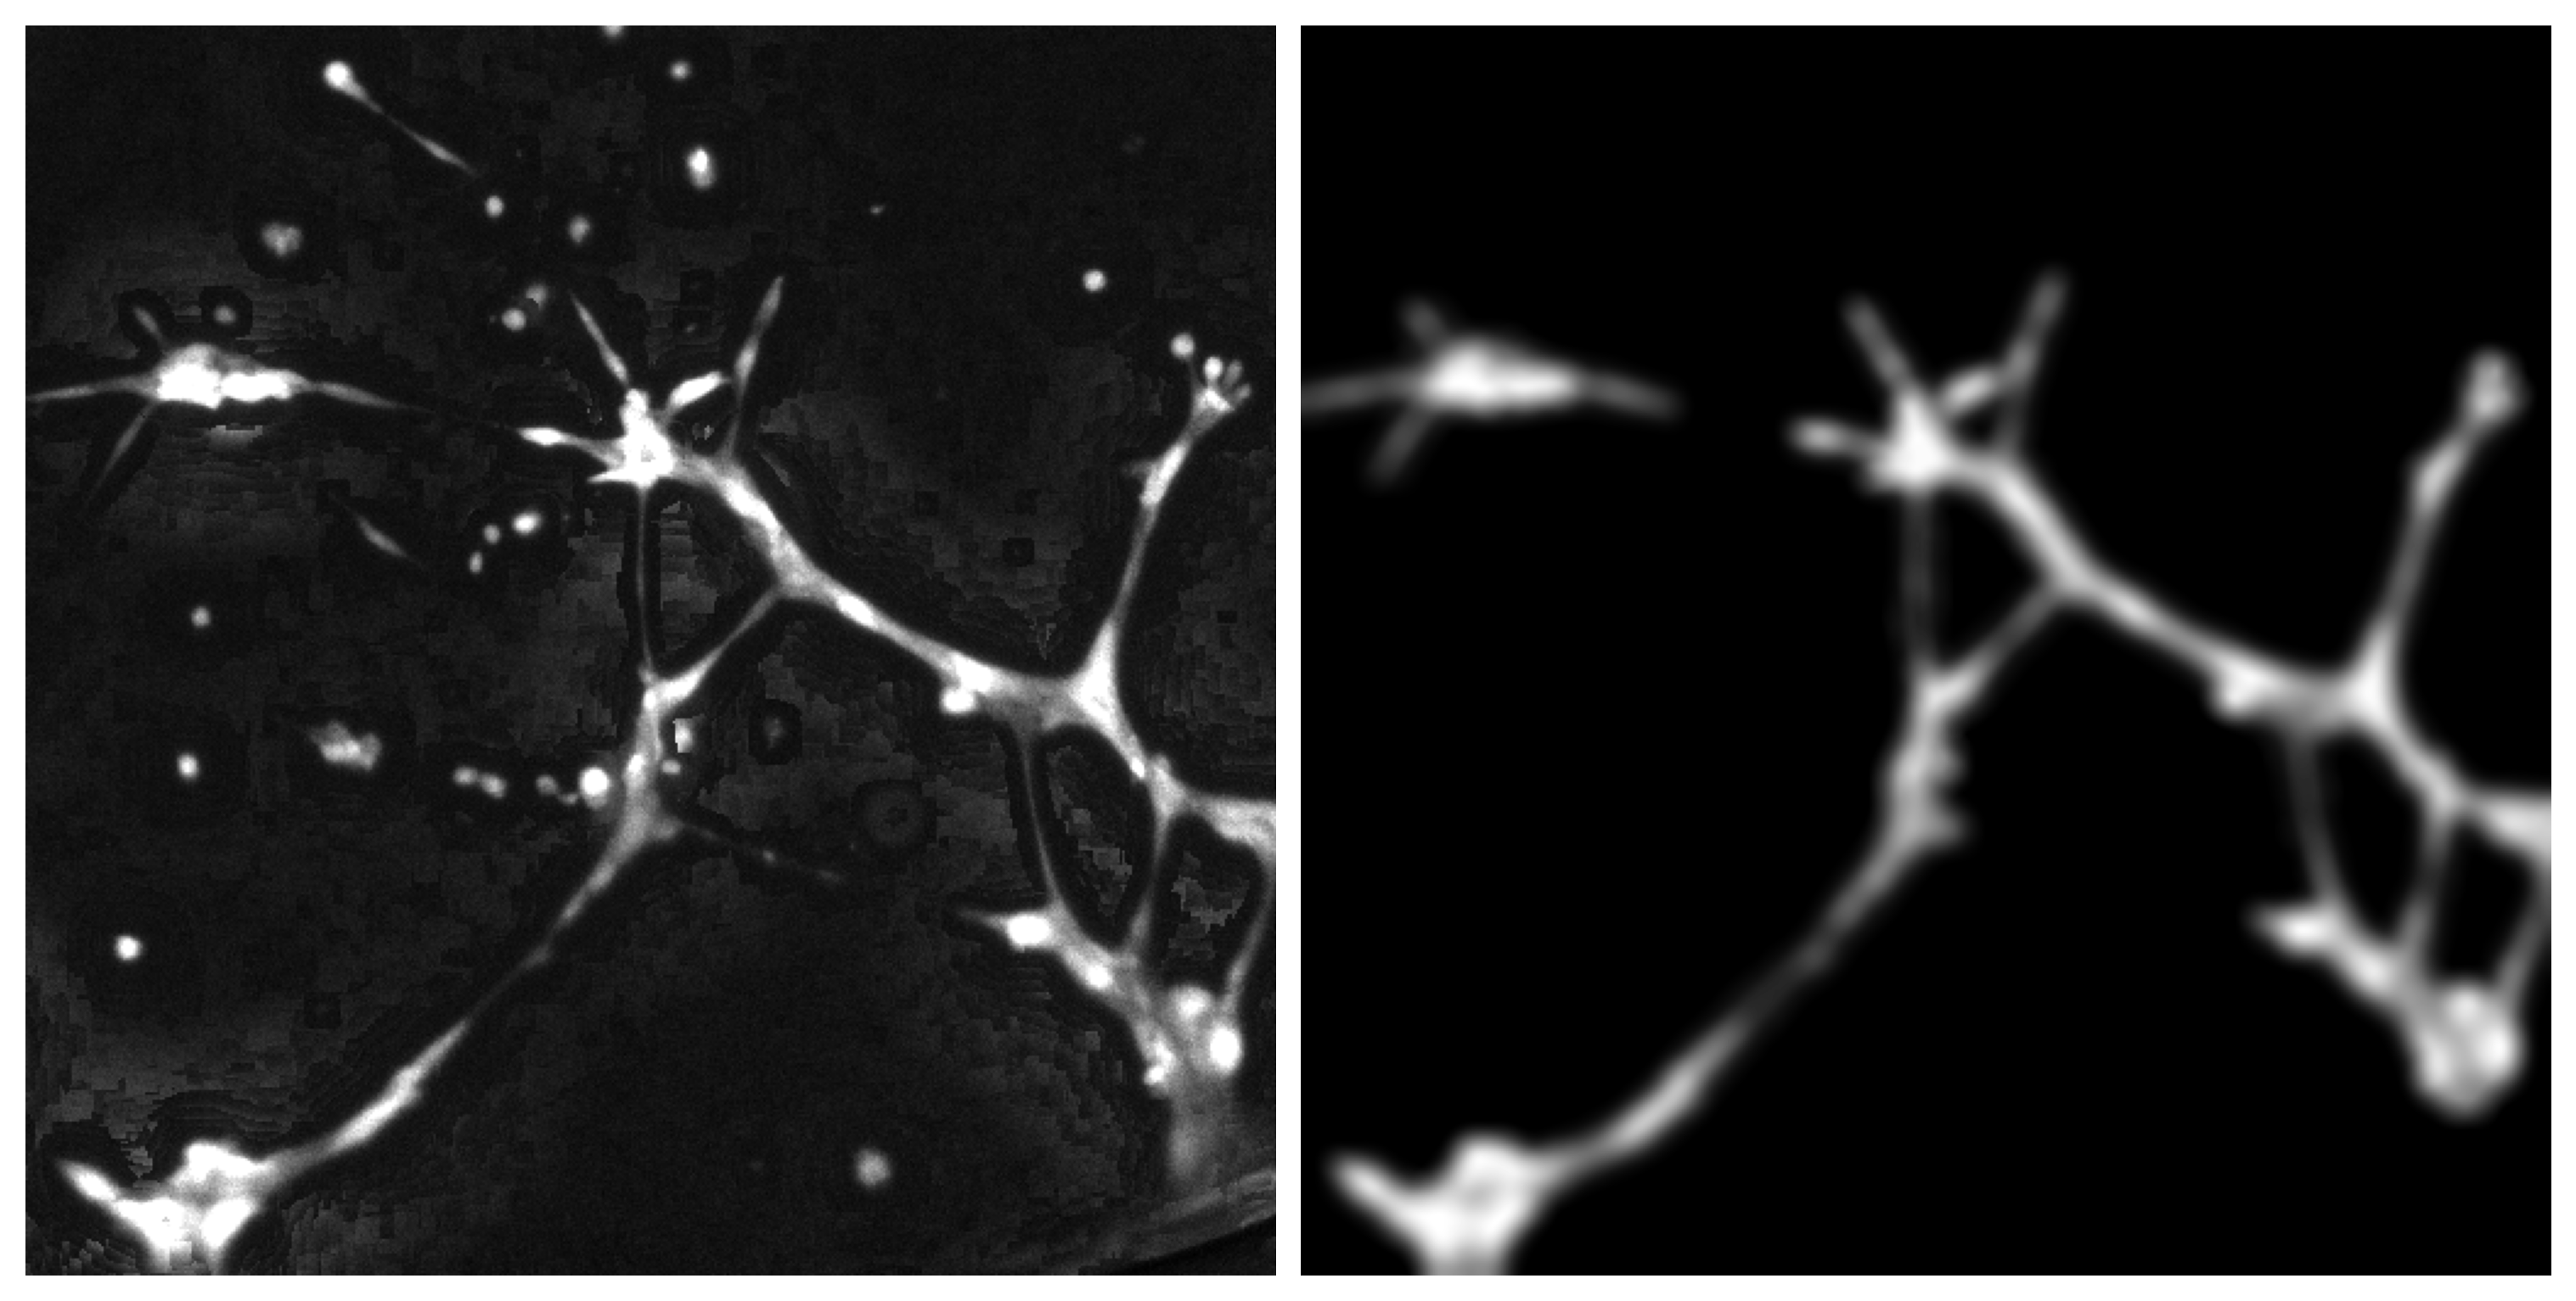

In [3]:
data_dir = "crops"
img_path, mask_path = [os.path.join(data_dir, f) for f in ("1_crop.png", "1_mask.png")]
img, mask = [cv2.imread(f, 0) for f in (img_path, mask_path)]
mask = remove_small_objects_in_mask(mask, 150)
mask = cv2.dilate(mask, np.ones((10, 10), np.uint8))
img_original = np.copy(img)
img = exposure.equalize_adapthist(img)
img[mask == 0] = 0
img = img.astype(np.float32)
#img = blur(img)
img = cv2.bilateralFilter(img, 15, 75, 75)
img = (img*256).astype(np.double)
#img = sharpen(img)
#img = blur(img)
show([img_original, img])

In [9]:
#im_rgb = cv2.cvtColor(img_original, cv2.COLOR_GRAY2RGB)
#for delta1 in [0.5, 1, 2, 4, 8, 16, 32]:
#    for delta2 in [0.5, 1, 2, 4, 8, 16, 32]:
#        print(f'delta1: {delta1}, delta2: {delta2}')
#        verts, edges, barcode = compute_morse_skeleton_and_barcode(np.copy(img), delta1, delta2)
#        print(f'len(verts): {len(verts)}, len(edges): {len(edges)}')
#        img_out = im_rgb.copy()
#        print(f'Marking vertices...')
#        for v in verts:
#            img_out[round(v[0]), round(v[1])] = (0, 0, 255)
#        print(f'Writing image...')
#        cv2.imwrite(f'output/{delta1}_{delta2}.png', img_out)
verts, edges, barcode = compute_morse_skeleton_and_barcode(img, 1, 0.5)

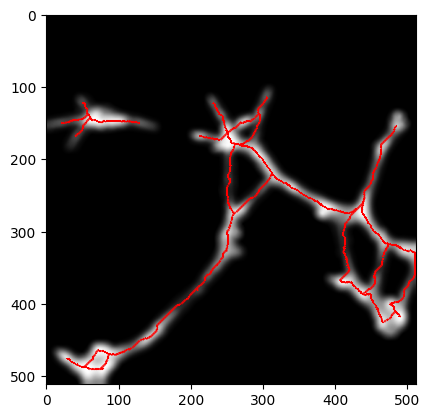

In [10]:
# Show the morse skeleton
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
plotGraph(verts, edges, ax)

<AxesSubplot: title={'center': 'Persistence barcode'}>

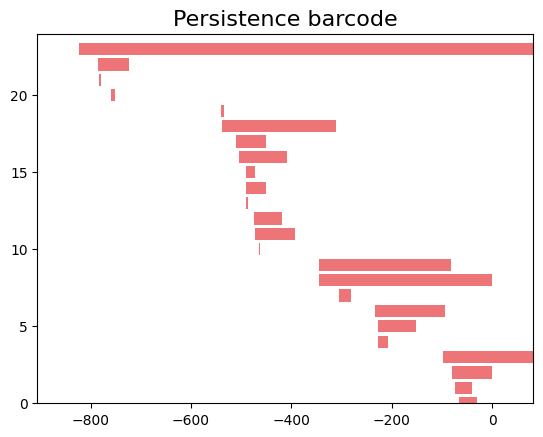

In [11]:
# Show the barcode
gd.plot_persistence_barcode(barcode)

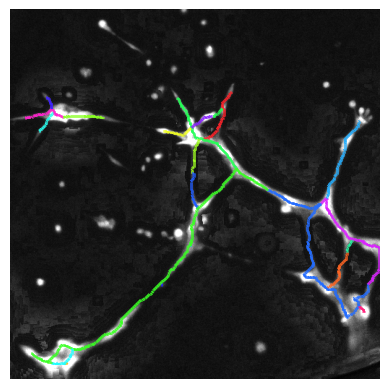

In [27]:
ax = plt.gca()
ax.imshow(img_original, cmap='gray')
colored_edges, colored_barcode = compute_colored_tree_and_barcode(verts, edges)
plot_colored_tree(colored_edges, ax, linewidth=2)

<AxesSubplot: title={'center': 'Persistence barcode'}>

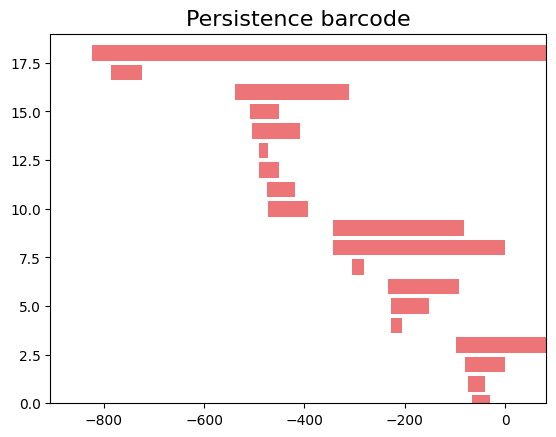

In [30]:
# Show the barcode
gd.plot_persistence_barcode(barcode)

In [28]:
MIN_LENGTH=10
barcode_filtered = []
for bar in barcode:
    bar_length = abs(bar[1]-bar[0])
    if bar_length >= MIN_LENGTH:
        barcode_filtered.append(bar)

barcode = np.array(barcode_filtered)

In [8]:
#with open('out.txt', 'w') as f:
#    filt_out_dir = 'output/filters'
#    sums = {}
#    for fname in os.listdir(filt_out_dir):
#        if fname.endswith('.png'):
#            f_path = os.path.join(filt_out_dir, fname)
#            img = cv2.imread(f_path, 0)
#            # TODO: Compute morse skeleton and barcode for each image to find the best one
#            # ALSO: DETECT BLACK RIDGES BETWEEN WHITE RIDGES
#            # ASSUME: Topology of the mask is correct (mask should be dilated without filling holes)
#            sums[fname] = np.sum(img)
#    for k, v in sorted(sums.items(), key=lambda item: item[1]):
#        x = f.write(f'{k}: {v}\n')

FileNotFoundError: [Errno 2] No such file or directory: 'output/filters'